# Deep Learning on Differential Equations: a Case Study with NODEs and the Double Pendulum

## Introduction and Review of Literature

In this project, our goal was to learn how deep neural networks perform on physics-related problems when the neural network itself has physics-related concepts built into its architecture. The particular problem we used to investigate this question was prediction of the future state of a double pendulum system, as the system is governed by relatively simple ordinary differential equations (ODEs) but exhibit chaotic behavior, making the learning task nontrivial. Using a deterministic (if chaotic) system allowed us to generate effectively infinite data as we needed it; when data was required for training or validation, we simply generated random starting points and used the differential equations to generate time series beginning with those points.

We focused primarily on neural ODEs (NODEs) in our experiments. NODEs are in some sense a conceptual extension of residual networks (ResNets) or recurrent neural networks (RNNs) in the sense that they represent relevant information about a time series through the use of a hidden state, which is updated as time moves forward (Chen, Rubanova, Bettencourt \& Duvenaud). However, while ResNets and RNNs perform updates in discrete time, NODEs operate in continuous time. Effectively, an RNN or similar model is trained to approximate the function that maps from the value of the hidden state at time index $t$ to the value of the hidden state at time $t+1$. A NODE instead approximates a continuous derivative of the hidden state at any time. This allows the trained neural network to be used as the derivative function in a black-box numerical ODE solver, the result of which can be decoded into a prediction at an arbitrary future time with constant computational cost. Put another way, NODEs mimic the limit of applying RNNs to a problem as the size of the discrete timestep used by the RNNs goes to 0.

NODEs can be applied to problems in physics quite naturally. Many physical problems involve differential equations, and any such problem could benefit from using a NODE. Using a NODE when a differential equation is involved is a good inductive hypothesis, as we demonstrate in the rest of this paper; however, it is worth noting that in the presence of noise, NODEs may benefit from additional structures that help mitigate the effect of noise.

We also considered applying Physics-Informed Neural Networks (PINNs) to the task of predicting future states of a double pendulum system. PINNs are deep neural networks whose objective function contains a term penalizing divergence from observed training data as well as a term penalizing divergence from some amount of preexisting knowledge about the physics of the system.

A wide variety of architectures and approaches fall under this umbrella. The authors who introduced the term (Raissi, Perdikaris, \& Karniadakis) first described a method with high physics knowledge that was effectively a neural network used to solve a particular initial value problem. Other researchers applied this general method to the double pendulum problem and found that PINNs can fail to capture chaotic dynamics because they deviate slightly from given initial conditions in order to match training trajectories (Steger, Rohrhofer, \& Geiger). On the other hand, later works took the opposite approach and set out to derive the governing equations of motion from data, such as Dufera, T. T. We were most interested in a hybrid approach such as that described by Karniadakis et al, in which models learn from both data and some pre-knowledge about system physics.

The most obvious initial investigation to us was the application of a straightforward multilayer perceptron (MLP) model with a PINN loss to map between discrete time points in the state of the system. In other words, we would train a neural network to take in the positions and velocities of both pendulums and output a prediction for those values a small, constant time interval later. However, upon further reflection, we realized that in the case that training data are generated without noise, the data perfectly follow the physics, and the data loss and the physics loss are equivalent. As a result, the network would not truly be a PINN. We thus chose to focus mostly on NODEs, and use "PINNs" (which here are equivalent to a MLP with a data-only loss) as a control for comparison purposes.

In [ ]:
from matplotlib import animation
animation.writer = animation.writers['ffmpeg']
from animation_generation import generate_animation_three_double_pendulum_systems
import numpy as np

# This takes ~35 seconds to run on one of the author's machines
generate_animation_three_double_pendulum_systems(l1=1.0, l2=1.0, m1=1.0, m2=1.0, t_final=20.0,
                        animation_name='chaos_demonstration', initial_offset=1e-6, num_tsteps=2000,
                        theta1_init=np.pi - 1e-1, theta2_init=np.pi + 1e-1, z1_init=0.0, z2_init=0.0)

<video src='chaos_demonstration.mp4' controls>

Figure 1. Animation of double pendulum simulated using SciPy.integrate's solve_ivp. Figure can be re-generated with different parameters if desired.

## Methods

We forewent a traditional dataset in favor of online data generation to ease comparison across various tasks. We generated data using RK4 with $\Delta t = 0.005\mathrm{s}$ on the true derivative of the double pendulum system to create a ground-truth trajectory. When generating noisy data, we then injected noise by adding $\boldsymbol{\varepsilon} \sim \mathcal{N}(\textbf{0}, \sigma^2 I)$ to the trajectory.

The control model was a feedforward multilayer perceptron with 3 hidden layers of dimension 30. Its training data were noiseless and all used pendula with equal masses (1kg) and equal lengths (1m); they consisted of input-output pairs of four variables each, with the angles and angular velocities of each pendulum at one point in time as input and the output being those same four variables .005s later. Angles were generated uniformly between $-\pi$ and $\pi$ radians, and velocities were chosen from a normal distribution centered at 0. Training was done for 450,000 epochs, each of which consisted of $2^{15}$ training pairs. Loss was a simple mean squared error (MSE) on vectors in $\mathbb{R}^4$.

Our NODEs were MLPs with tanh nonlinearities. The model was then run through the \textit{odeint} function of the \textit{torchdiffeq} package developed by the original authors of the NODE paper (Chen, Rubanova, Bettencourt \& Duvenaud) to produce the new sequence of timesteps. Again, loss was MSE on the resulting vectors. The specifics of model size, amount of noise, trajectory length and number of training samples were varied during our ablation study, as summarized below.
* For model size, we had 3 models with 1, 2 and 3 hidden layers. The size of the hidden layers were [32], [64, 64], and [64, 128, 64], respectively.
* We then assigned maximum and minimum trajectory lengths and had the dataset generate trajectories of lengths uniformly sampled between them. Our trajectory lengths were then chosen to be in one of the following bins: [3, 8], [10, 15], [18, 23].
* We added noise by adding $\boldsymbol{\varepsilon} \sim \mathcal{N}(\textbf{0}, \sigma^2 I)$ for $\sigma^2\in \{0.05, 0.5\}$. We also trained with no noise (denoted $\sigma^2 = 0$ in the tables in this paper).
* We tried training for a total of $|X| \in \{200, 500, 1000\}$ trajectories.

<div style="text-align: center;">
  <img src="training_loss.png" alt="Figure 2. Sample training loss curve" style="width:40%;">
  <p><b>Figure 2. Sample training loss curve</b></p>
</div>

Our NODE used tanh for its nonlinearities, and layers in the middle were twice as large as layers near the edge. Our PINNs and vanilla MLPs were similar, but used ReLU for the nonlinearities. See Figure 2 above for a sample training trajectory.

## Results

We found that . . .

## Conclusions

We conclude that . . .

## References

We referenced . . .

## Runable Code for a NODE

In [1]:
!pip install torchdiffeq

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint
from torch.utils.data.dataloader import DataLoader
import argparse
from tqdm import tqdm
from scipy.integrate import solve_ivp
from torch.utils.data.dataloader import Dataset
import matplotlib.pyplot as plt

In [3]:
# class FeedForward(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(8, 30)
#         self.linear2 = nn.Linear(30,30)
#         self.linear3 = nn.Linear(30,30)
#         self.linear4 = nn.Linear(30,4)
#         self.relu = nn.ReLU()
#     def forward(self, x):
#         x = self.relu(self.linear1(x))
#         x = self.relu(self.linear2(x))
#         x = self.relu(self.linear3(x))
#         x = self.linear4(x)
#         x = torch.clamp(x, -1e6, 1e6)
#         return x


class Pendulum_Data(Dataset):
    def __init__(self, min_length=1, max_length=1, G=9.81, delta_t=0.005, size=2**15):
        self.__dict__.update(locals())

    @staticmethod
    def derivatives(t, state, params, G=9.81):
        L1, L2, m1, m2 = params
        theta1, z1, theta2, z2 = state
        delta = theta2 - theta1

        denominator1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
        denominator2 = (L2 / L1) * denominator1

        dtheta1_dt = z1
        dz1_dt = (
                (m2 * L1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
                 + m2 * G * np.sin(theta2) * np.cos(delta)
                 + m2 * L2 * z2 ** 2 * np.sin(delta)
                 - (m1 + m2) * G * np.sin(theta1))
                / denominator1
        )
        dtheta2_dt = z2
        dz2_dt = (
                (-m2 * L2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
                 + (m1 + m2) * G * np.sin(theta1) * np.cos(delta)
                 - (m1 + m2) * L1 * z1 ** 2 * np.sin(delta)
                 - (m1 + m2) * G * np.sin(theta2))
                / denominator2
        )

        return np.array([dtheta1_dt, dz1_dt, dtheta2_dt, dz2_dt])

    def run_simulation(self, theta1_init, theta2_init, l1, l2, m1, m2, v1, v2, t_eval):
        state_0 = [theta1_init, v1, theta2_init, v2]
        # Solve the system
        params = [[l1, l2, m1, m2]]
        solution = solve_ivp(
            Pendulum_Data.derivatives, (0, t_eval[-1]), state_0, t_eval=t_eval, args=params,
        )
        # Return data as dictionary
        return np.array(
            [[l1] * len(t_eval), [l2] * len(t_eval), [m1] * len(t_eval), [m2] * len(t_eval), *solution.y, t_eval]).T

    def __getitem__(self, i):
        t_final = (np.random.randint(self.min_length, self.max_length + 1)+1) * self.delta_t  # the extra +1 makes it so the arange has the right number of steps
        theta1_init, theta2_init = np.random.uniform(-np.pi, np.pi, 2)
        l1, l2 = np.clip(np.random.normal(1, .5, 2), 0.1, 3)
        m1, m2 = np.clip(np.random.normal(1, .5, 2), 0.1, 3)
        v1, v2 = np.random.normal(size=2)
        theta =  self.run_simulation(theta1_init=theta1_init, theta2_init=theta2_init, l1=l1, l2=l2, m1=m1, m2=m2, v1=v1,
                                   v2=v2, t_eval=np.arange(0, t_final, self.delta_t))
        return theta[:-1], theta[1:]

    def __len__(self):
        return self.size

In [4]:
class ODEFunc(nn.Module):
    def __init__(self, dims):
        super(ODEFunc, self).__init__()
        self.num_calls = 0
        self.net = nn.Sequential(
            nn.Linear(5, dims[0]),  # state: (theta1, w1, theta2, w2, t)
            nn.Tanh(),
        )
        if len(dims) > 1:
            for i in range(1,len(dims)):
                self.net.append(nn.Linear(dims[i-1], dims[i]))
                self.net.append(nn.Tanh())
        self.net.append(nn.Linear(dims[-1], 5))

    def forward(self, t, y):
        # y has shape (batch_size, 4)
        self.num_calls += 1
        return self.net(y)

In [5]:
def one_step_error(y, y_hat, lambda_=0):
    """
    Returns L(t-1) = ||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||
    Agrees with (3.13) when lambda_=1.  Note the shift in index.

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    lambda : regularization parameter
    """
    theta, theta_hat = y[:, :2], y_hat[:, :2]
    theta_prime, theta_prime_hat = y[:, 2:-1], y_hat[:, 2:-1]

    return (np.linalg.norm(theta - theta_hat, axis=1) +
            lambda_ * np.linalg.norm(theta_prime - theta_prime_hat, axis=1))

def time_to_divergence(y, y_hat, lambda_=0, tol=1e-1):
    """
    Returns min {t : (||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||) >= tol}

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    t_idx : The index such that y[t_idx] = y(T)
    lambda : regularization parameter
    tol : maximum error
    """
    idx = np.where(one_step_error(y, y_hat, lambda_) >= tol)
    return np.min(idx[0]) if len(idx[0]) != 0 else len(y_hat)

def global_error(t_idx, y, y_hat, lambda_=0):
    """
    Returns max_{t<T} (||theta(t) - theta_hat(t)|| + lambda_ ||theta'(t) - theta_hat'(t)||)
    Agrees with spherical error (3.11) when lambda_=1 and t_idx is as large as possible

    y : True values of theta (first two columns) and theta' (last two columns)
    y_hat : predicted values of y
    t_idx : The index such that y[t_idx] = y(T)
    lambda : regularization parameter
    """
    return max(one_step_error(y, y_hat, lambda_)[:t_idx])

In [6]:
def train_model(num_epochs, dims, std_dev, min_steps):
    max_steps = min_steps + 5
    G = 9.81
    delta_t = 0.005
    lr = 1e-3
    weight_decay = 1e-4
    batch_size = 1
    lam = 0.5
    save_every = 100
    val_every = 25
    val_size = 100

    # Set model, optimizer and loss
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = ODEFunc(dims)
    criterion = nn.MSELoss()
    model = model.to(device=device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    losses = []

    # Training
    data = Pendulum_Data(min_steps, max_steps, G, delta_t, batch_size)
    dl = DataLoader(data, batch_size=batch_size)
    train_losses = []
    val_losses = []

    for i in tqdm(range(num_epochs)):
        train_losses_local = []
        # each batch is as long as the dataset, so an epoch is one batch
        for X_batch, y_batch in dl:
            X_batch += np.random.normal(0, std_dev, X_batch.shape)
            X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
            optimizer.zero_grad()

            # get prediction and make a tuple to pass to the loss
            y_pred = odeint(model, X_batch[:, :, 4:], delta_t * torch.arange(len(X_batch)+1))[1:]
            y_batch = y_batch[:, :, 4:]  # remove mass/length information from outputs
            loss_args = (y_pred.squeeze(), y_batch.squeeze())

            # calculate loss and backprop
            loss = criterion(*loss_args)
            loss.backward()
            train_losses_local.append(loss.item())
            optimizer.step()
        train_losses.append(np.mean(train_losses_local))

        if (i + 1) % val_every == 0:
            model.eval()
            val_losses_local = []

            # run val_size batches to test validation error
            for j in range(val_size):
                for X_batch, y_batch in dl:
                    X_batch += np.random.normal(0, std_dev, X_batch.shape)
                    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
                    optimizer.zero_grad()

                    # get prediction
                    y_pred = None
                    loss_args = None
                    y_pred = odeint(model, X_batch[:, :, 4:], delta_t * torch.arange(len(X_batch) + 1))[1:]
                    y_batch = y_batch[:, :, 4:]  # remove mass/length information from outputs
                    loss_args = (y_pred.squeeze(), y_batch.squeeze())

                    # calculate loss, then average
                    loss = criterion(*loss_args)
                    val_losses_local.append(loss.item())
            val_losses.append(np.mean(val_losses_local))
            model.train()

    return model, train_losses, val_losses

In [8]:
num_epochs = 1000
dims = [64,128,64]
std_dev = 0.05
min_steps = 18

model, train_losses, val_losses = train_model(num_epochs, dims, std_dev, min_steps)
data = Pendulum_Data(min_steps, min_steps+5, 9.81, 0.005, 1)
dl = DataLoader(data, batch_size=1, shuffle=False)

100%|██████████| 1000/1000 [00:58<00:00, 17.18it/s]


Time to Divergence: 0
Global Error 0.16343695 



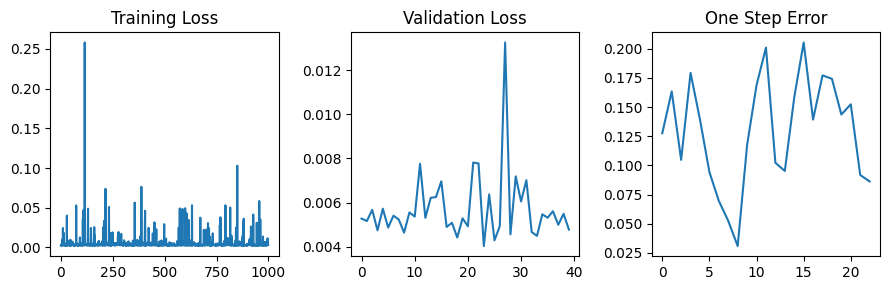

In [12]:
for  X_batch, y_batch in dl:
    X_batch += np.random.normal(0, std_dev, X_batch.shape)
    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
    y_pred = odeint(model, X_batch[:, :, 4:], 0.005 * torch.arange(len(X_batch)+1))[1:]
    y_batch = y_batch[:, :, 4:]

ttd = time_to_divergence(y_batch.detach().numpy().squeeze(), y_pred.detach().numpy().squeeze(), lambda_=1)
ge = global_error(len(X_batch)+1, y_batch.detach().numpy().squeeze(), y_pred.detach().numpy().squeeze(), lambda_=1)
ose = one_step_error(y_pred.squeeze().detach().numpy(), y_batch.squeeze().detach().numpy(), 1)

print("Time to Divergence:", ttd)
print("Global Error", ge, "\n")

plt.figure(figsize=(9, 3))
plt.subplot(131)
plt.plot(train_losses)
plt.title("Training Loss")

plt.subplot(132)
plt.plot(val_losses)
plt.title("Validation Loss")

plt.subplot(133)
plt.plot(ose)
plt.title("One Step Error")

plt.tight_layout()
plt.show()